In [1]:
import numpy as np
import cv2
import os
import glob
from imshowtools import imshow, cvshow
from tqdm.auto import tqdm

In [2]:
calib_dir = '/fastscratch/data/st_lucia/calib'
img_dir = '/cephshare/compsci/public/st_lucia/images'
os.path.exists(calib_dir), os.path.exists(img_dir)

(True, True)

In [3]:
imgs = glob.glob(f'{img_dir}/*.bmp')
imgs_cam0 = glob.glob(f'{img_dir}/cam0_*.bmp')
imgs_cam1 = glob.glob(f'{img_dir}/cam1_*.bmp')

len(imgs), len(imgs_cam0), len(imgs_cam1)

(66394, 33197, 33197)

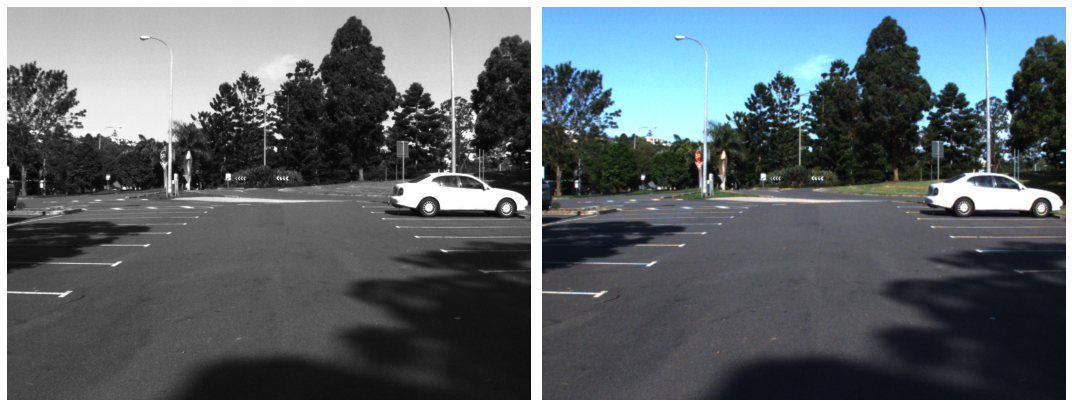

In [4]:
img_sample = cv2.imread(imgs[0])
img_sample_debayered = cv2.cvtColor(img_sample[:, :, 0], cv2.COLOR_BAYER_GB2RGB)
cvshow(img_sample, img_sample_debayered, size=(15, 15))

In [5]:
cam0_intrinsics_file = os.path.join(calib_dir, 'cam0_intrinsics.xml')
cam1_intrinsics_file = os.path.join(calib_dir, 'cam1_intrinsics.xml')
cam0_distortion_file = os.path.join(calib_dir, 'cam0_distortion.xml')
cam1_distortion_file = os.path.join(calib_dir, 'cam1_distortion.xml')

[os.path.exists(f) for f in [cam0_intrinsics_file, cam1_intrinsics_file, cam0_distortion_file, cam1_distortion_file]]

[True, True, True, True]

In [6]:
fs = cv2.FileStorage(cam0_intrinsics_file, cv2.FILE_STORAGE_READ)
cam0_intrinsics = fs.getNode('Intrinsics').mat()
cam0_intrinsics

array([[1.2465616e+03, 0.0000000e+00, 5.3228790e+02],
       [0.0000000e+00, 1.2470923e+03, 3.8360410e+02],
       [0.0000000e+00, 0.0000000e+00, 1.0000000e+00]], dtype=float32)

In [7]:

fs = cv2.FileStorage(cam1_intrinsics_file, cv2.FILE_STORAGE_READ)
cam1_intrinsics = fs.getNode('Intrinsics').mat()
cam1_intrinsics

array([[1.2448051e+03, 0.0000000e+00, 5.0663550e+02],
       [0.0000000e+00, 1.2458157e+03, 3.9070480e+02],
       [0.0000000e+00, 0.0000000e+00, 1.0000000e+00]], dtype=float32)

In [8]:
fs = cv2.FileStorage(cam0_distortion_file, cv2.FILE_STORAGE_READ)
cam0_distortion = fs.getNode('Distortion').mat()
cam0_distortion

array([[-0.32598   ],
       [ 0.18151   ],
       [ 0.00032617],
       [-0.00044783],
       [ 0.        ]], dtype=float32)

In [9]:

fs = cv2.FileStorage(cam1_distortion_file, cv2.FILE_STORAGE_READ)
cam1_distortion = fs.getNode('Distortion').mat()
cam1_distortion

array([[-3.2512e-01],
       [ 1.7124e-01],
       [ 3.1879e-05],
       [ 3.4777e-05],
       [ 0.0000e+00]], dtype=float32)

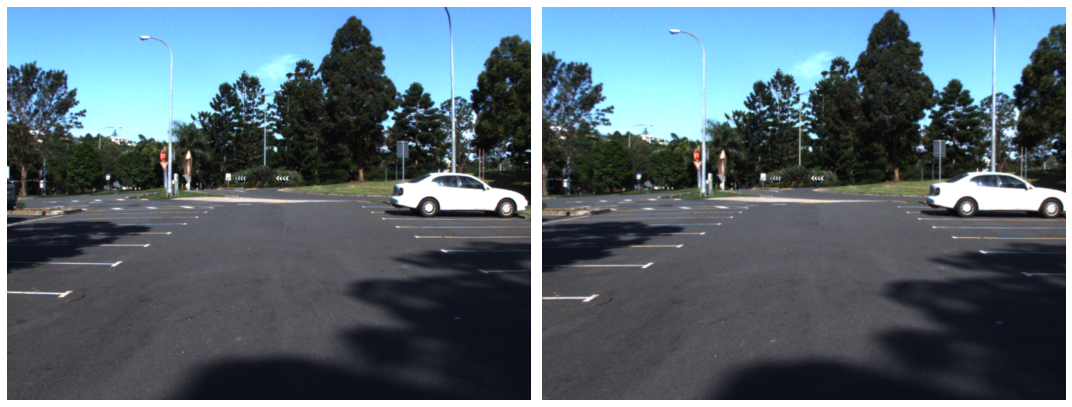

In [10]:
img_sample_undistorted = cv2.undistort(img_sample_debayered, cam0_intrinsics, cam0_distortion)
cvshow(img_sample_debayered, img_sample_undistorted, size=(15, 15))

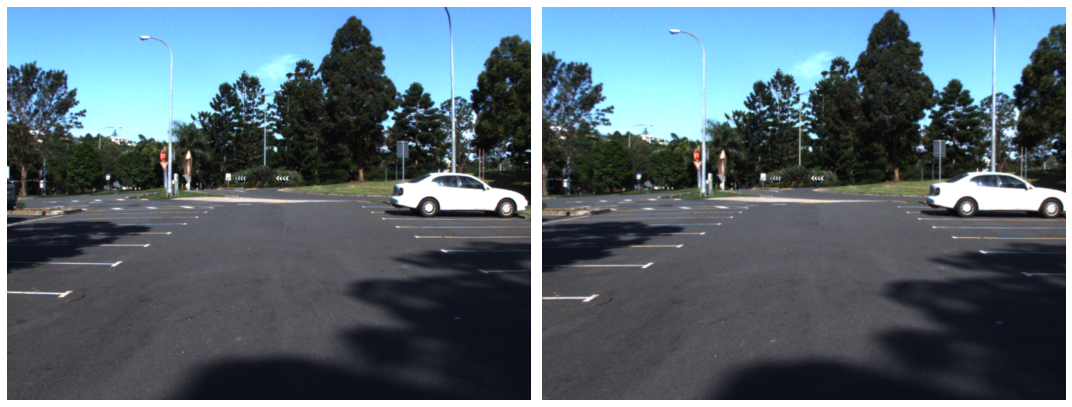

In [11]:
from camera_model import CameraModel

cm = CameraModel(calib_dir)
cvshow(img_sample_debayered, cm.undistort(img_sample_debayered, cam='cam0'), size=(15, 15))

In [14]:
from multiprocessing import Pool
output_dir = '/fastscratch/data/st_lucia/images/'
assert False, "Change output dir and comment me"

def undistort_save_cam0(img_path):
    img = cv2.imread(img_path)
    img_debayered = cv2.cvtColor(img[:, :, 0], cv2.COLOR_BAYER_GB2RGB)
    img_debayered_undistorted = cm.undistort(img_debayered, cam='cam0')
    img_filename_without_ext = os.path.splitext(os.path.basename(img_path))[0]
    outfile = os.path.join(output_dir, f'{img_filename_without_ext}.jpg')
    cv2.imwrite(outfile, img_debayered_undistorted)

def undistort_save_cam1(img_path):
    img = cv2.imread(img_path)
    img_debayered = cv2.cvtColor(img[:, :, 0], cv2.COLOR_BAYER_GB2RGB)
    img_debayered_undistorted = cm.undistort(img_debayered, cam='cam1')
    img_filename_without_ext = os.path.splitext(os.path.basename(img_path))[0]
    outfile = os.path.join(output_dir, f'{img_filename_without_ext}.jpg')
    cv2.imwrite(outfile, img_debayered_undistorted)


with Pool(processes=12) as p:
    list(tqdm(p.imap(undistort_save_cam0, imgs_cam0), total=len(imgs_cam0)))
    list(tqdm(p.imap(undistort_save_cam1, imgs_cam1), total=len(imgs_cam1)))

  0%|          | 0/33197 [00:00<?, ?it/s]

  0%|          | 0/33197 [00:00<?, ?it/s]

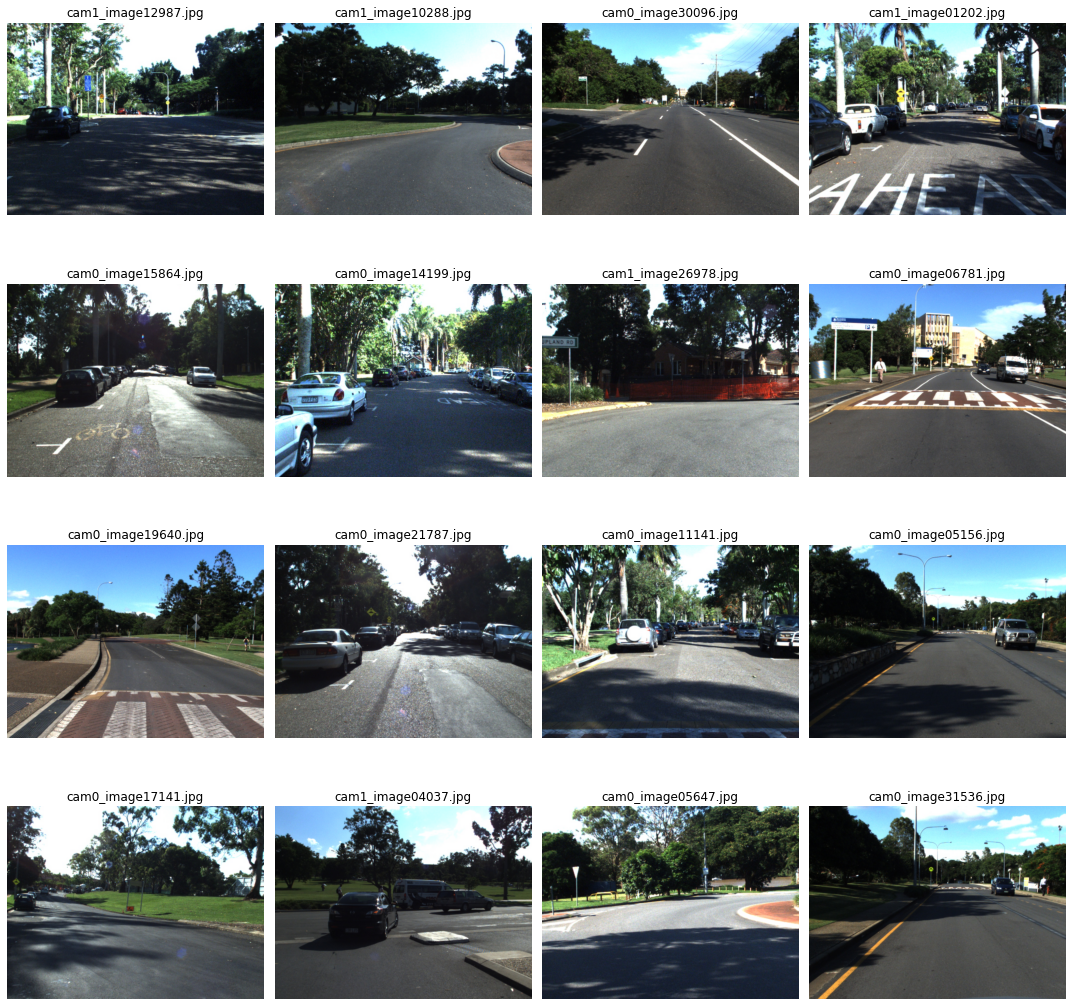

In [8]:
output_dir = '/fastscratch/data/st_lucia/images/'
output_imgs = glob.glob(f'{output_dir}/*.jpg')

cvshow(*[cv2.imread(output_imgs[i]) for i in range(16)], title=[os.path.basename(output_imgs[i]) for i in range(16)], size=(15, 15))